# Contenido
* [Casos totales](#1.)

* [Fallecimientos totales](#2.)

* [Nuevos casos](#3.)

In [2]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import numpy as np
import datetime
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
register_matplotlib_converters()

from scipy.optimize import curve_fit
from datetime import timedelta
from datetime import datetime
from io import StringIO
from urllib import request as url_request

In [12]:
days_past = -2 # days beyond the start of the data to plot
days_future = 30 # days after the end of the data to predict and plot

myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
show_every = 2 # int value that defines how often to show a date in the x axis.

coeff_std = 1.1 # coefficient that defines how many standard deviations to use
coeff_std_d = 0.4

In [13]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic(x, L, k, x0, y0):
    """
    General Logistic function.

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's maximum value
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the sigmoid's midpoint
        y0   float, curve's shift in the y axis
    """
    y = L / (1 + np.exp(-k*(x-x0))) + y0
    return y

## Defining functions

In [14]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic_derivative(x, L, k, x0):
    """
    General Gaussian like function (derivative of the logistic).

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's integral (area under the curve)
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the max value
    """
    y = k * L * (np.exp(-k*(x-x0))) / np.power(1 + np.exp(-k*(x-x0)), 2)
    return y

In [15]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def fit_curve(curve, ydata, title, ylabel, last_date, coeff_std):
    xdata = np.array(list(range(-len(ydata), 0))) + 1

    if curve.__name__ == 'logistic':
        p0=[20000, 0.5, 1, 0]
        bounds=([0, 0, -100, 0], [200000, 10, 100, 1])
        params_names = ['L', 'k', 'x0', 'y0']
    elif curve.__name__ == 'logistic_derivative':
        p0=[20000, 0.5, 1]
        bounds=([0, 0, -100], [200000, 10, 100])
        params_names = ['L', 'k', 'x0']
    else:
        print('this curve is unknown')
        return -1

    popt, pcov = curve_fit(curve, xdata, ydata, p0=p0, bounds=bounds)

    descr = 'Fit parameters: '
    
    for i, param in enumerate(params_names):
        descr = descr + "{}={:.3f}".format(param, popt[i])
        if i < len(params_names) - 1:
            descr = descr + ', '
    print(descr)

    perr = np.sqrt(np.diag(pcov))
    print(perr)

    pworst = popt + coeff_std*perr
    pbest = popt - coeff_std*perr

    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

    total_xaxis = np.array(list(range(-len(ydata) + days_past, days_future))) + 1

    date_xdata = [last_date + timedelta(days=int(i)) for i in xdata]
    date_total_xaxis = [last_date + timedelta(days=int(i)) for i in total_xaxis]

    future_axis = total_xaxis[len(ydata) - days_past:]
    date_future_axis = [last_date + timedelta(days=int(i)) for i in future_axis]
    
    start = (len(ydata) - days_past - 1) % show_every


    ax.plot(date_total_xaxis, curve(total_xaxis, *popt), 'r-', linewidth=6, label='fit')
    ax.bar(date_xdata, ydata, label='data')
    ax.fill_between(date_future_axis, curve(future_axis, *pbest), curve(future_axis, *pworst), 
        facecolor='red', alpha=0.2, label='std')
    
    ax.set_xticks(date_total_xaxis[start::show_every])
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title + ' - ' + str(last_date.strftime("%d-%m-%Y")))
    ax.legend(loc='upper left')
    ax.grid(True)

    return popt, perr

## Reading data
Los datos son obtenidos desde el Minsiterio de Sanidad en la página 

In [16]:
data = pd.read_csv('../data/final_data/dataCOVID19_es.csv')
Spain = data.groupby('fecha', as_index=False).sum()

In [17]:
Confirmed=Spain.casos.values
Deaths=Spain.muertes.values
nuevos_casos = [np.nan]+list(Spain.casos.values[1:] - Spain.casos.values[:-1])

dates=pd.to_datetime(Spain.fecha.values)

last_date = datetime.strptime(Spain.fecha.values[-1], "%Y-%m-%d")

# Total confirmed cases <a class="anchor" id="1."></a>
Casos para toda España confirmados, ajustados a una curva logística. Es una curva acumulada, de modo que el valor para el ultimo dia con datos corresponde a todos los casos qye ha en España y que han sido confirmados analíticamente.

Fit parameters: L=160159.817, k=0.222, x0=1.846, y0=0.000
[2.52479848e+04 1.21309742e-02 1.20554998e+00 3.55276409e+02]


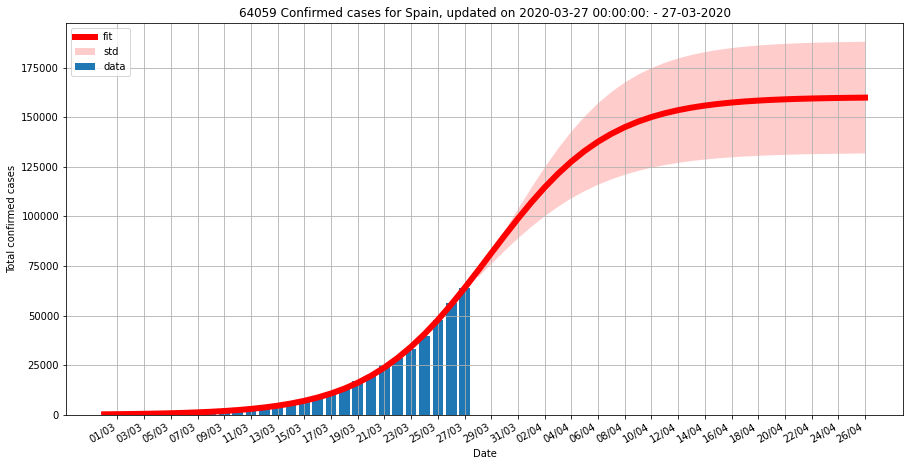

In [29]:
Titulo = '{:.0f} Confirmed cases for Spain, updated on {}:'.format(Confirmed[-1],dates[-1])
p_cont, err_cont = fit_curve(logistic, Confirmed, Titulo , 'Total confirmed cases', last_date, coeff_std);

Fit parameters: L=10200.328, k=0.301, x0=0.317, y0=0.000
[5.59169874e+02 6.98880036e-03 3.29607202e-01 9.24770404e+00]


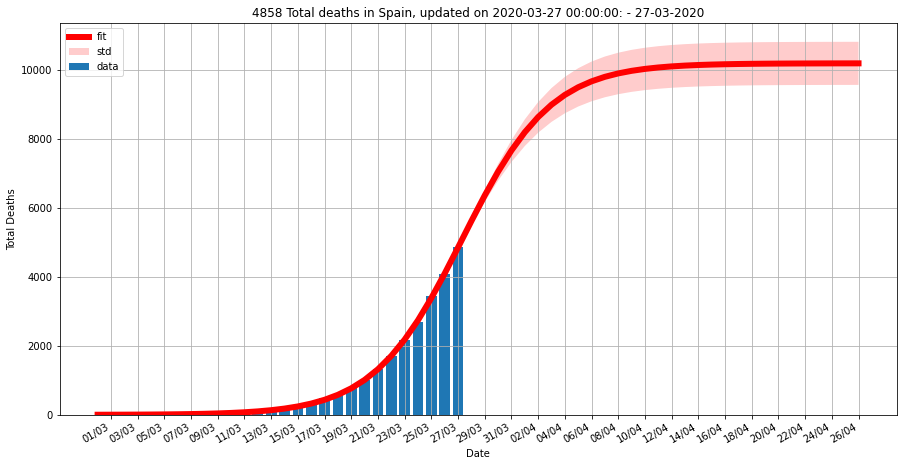

In [19]:
Titulo = '{:.0f} Total deaths in Spain, updated on {}:'.format(Deaths[-1],dates[-1])
p_dead, err_dead = fit_curve(logistic, Deaths, Titulo, 'Total Deaths', last_date, coeff_std)

# Total deaths <a class="anchor" id="2."></a>

Fallecimientos totales en España por día, ajustados a una gaussiana.

Fit parameters: L=10320.104, k=0.299, x0=0.887
[1.60348588e+03 2.87516437e-02 9.19273663e-01]


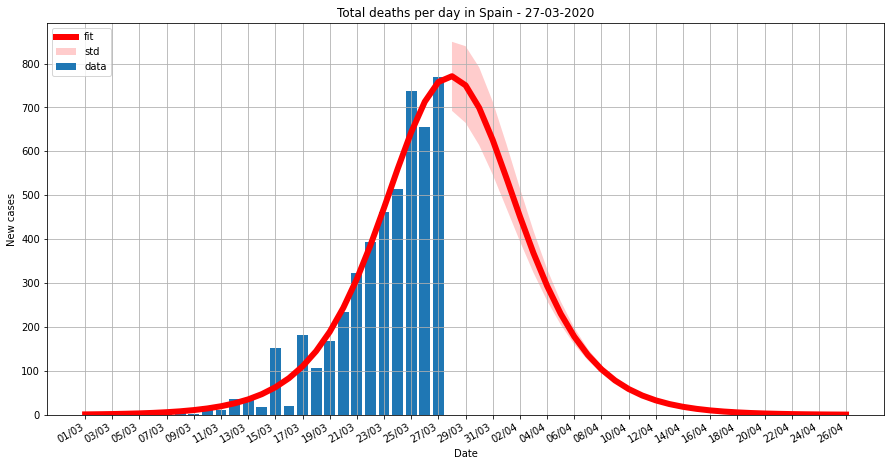

In [23]:
deathsPerDay=np.diff(Deaths)

Titulo = '{:.0f} deaths per day for Spain, updated on {}:'.format(deathsPerDay[-1],dates[-1])
fit_curve(logistic_derivative, deathsPerDay, 'Total deaths per day in Spain', 'New cases', last_date, coeff_std_d);

# Nuevos casos <a class="anchor" id="3."></a>

## En toda España

Fit parameters: L=200000.000, k=0.204, x0=4.103
[6.86920318e+04 2.68002587e-02 2.80016390e+00]


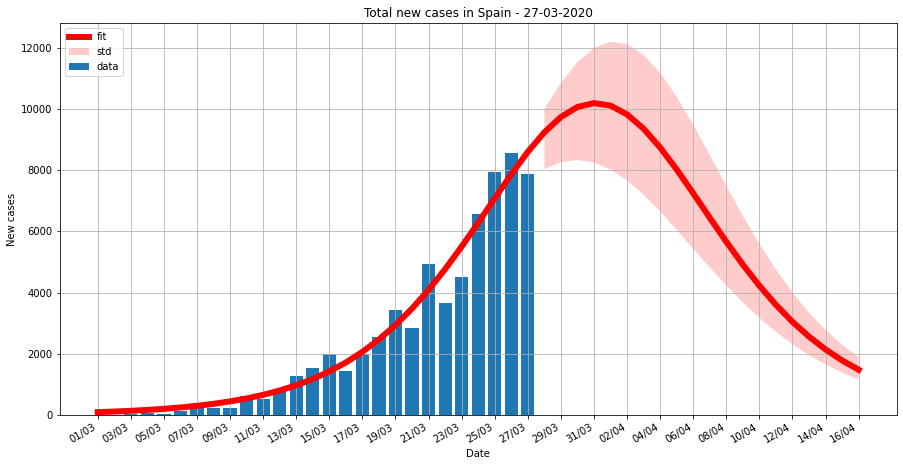

In [30]:
newCases=np.diff(Confirmed)

Titulo = '{:.0f} new cases for Spain, updated on {}:'.format(newCases[-1],dates[-1])
fit_curve(logistic_derivative, newCases, 'Total new cases in Spain', 'New cases', last_date, coeff_std_d);

In [25]:
tempVar=np.diff(Confirmed)
tempVar[tempVar==0]=np.nan
newCases=tempVar
datesNewCases=dates[1:]

In [26]:
growth_factor = newCases[1:] / newCases[:-1]
dates_growth_factor = datesNewCases[1:]

### Growth rates in Spain

In [27]:
print('Last growth factor: {:.3f}'.format(growth_factor[-1]))
print('Mean growth factor for the last 5 days: {:.3f}'.format(np.mean(growth_factor[-5:])))

Last growth factor: 0.918
Mean growth factor for the last 5 days: 1.180


### Nuevos casos por CCAA

Fit parameters: L=7202.040, k=0.244, x0=0.058
[1.89313461e+03 4.64629152e-02 1.91829058e+00]
Fit parameters: L=199999.979, k=0.185, x0=27.434
[6.75534124e+06 3.98372887e-02 1.89121431e+02]
Fit parameters: L=1200.401, k=0.271, x0=-3.695
[2.21228961e+02 5.81933605e-02 1.12712786e+00]
Fit parameters: L=1369.631, k=0.275, x0=-0.347
[2.71150186e+02 4.27550688e-02 1.27821491e+00]
Fit parameters: L=7619.040, k=0.234, x0=0.999
[3.18504525e+03 6.07023854e-02 3.16338797e+00]
Fit parameters: L=1950.403, k=0.227, x0=1.386
[4.49782323e+02 3.06331994e-02 1.78485197e+00]
Fit parameters: L=2685.147, k=0.276, x0=3.507
[1.76880906e+03 6.34932129e-02 3.91414015e+00]
Fit parameters: L=12921.957, k=0.209, x0=4.294
[8.90645598e+03 5.23655234e-02 5.45292357e+00]
Fit parameters: L=16163.051, k=0.209, x0=5.420
[7.34512810e+03 2.81419552e-02 3.46165388e+00]
Fit parameters: L=18171.448, k=0.378, x0=-1.526
[2.58958282e+03 5.55573506e-02 6.47845464e-01]
Fit parameters: L=195559.631, k=0.915, x0=11.152
[6.25384415e

/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Fit parameters: L=200000.000, k=0.140, x0=16.167
[7.45901982e+05 5.36667566e-02 3.49076770e+01]
Fit parameters: L=64.867, k=0.190, x0=-4.145
[41.57427381  0.13261165  5.58125584]
Fit parameters: L=199999.999, k=0.186, x0=30.755
[1.61998362e+07 5.09876489e-02 4.45633132e+02]
Fit parameters: L=45798.967, k=0.149, x0=22.202
[3.23687462e+05 3.85733853e-02 5.42237805e+01]
Fit parameters: L=124664.094, k=0.165, x0=20.159
[9.17612213e+05 4.41302318e-02 5.12119024e+01]


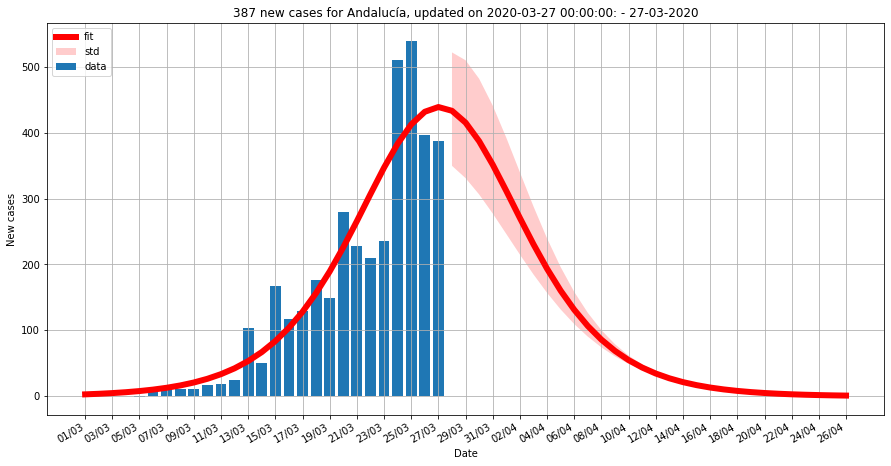

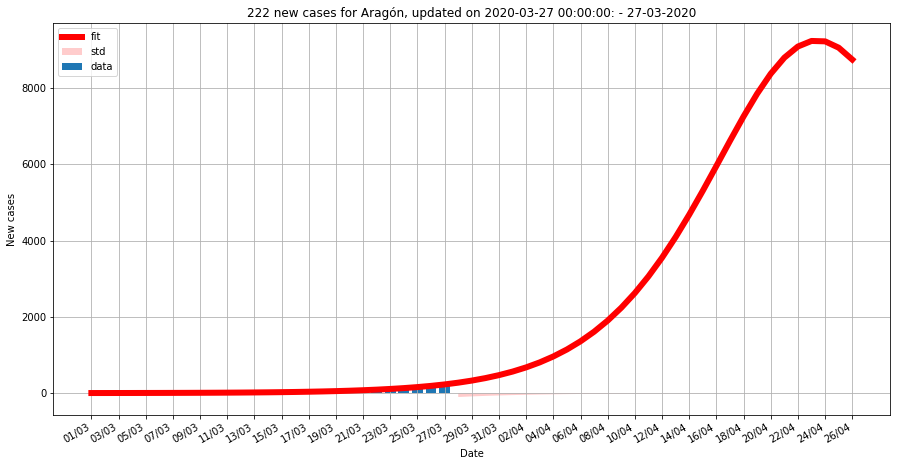

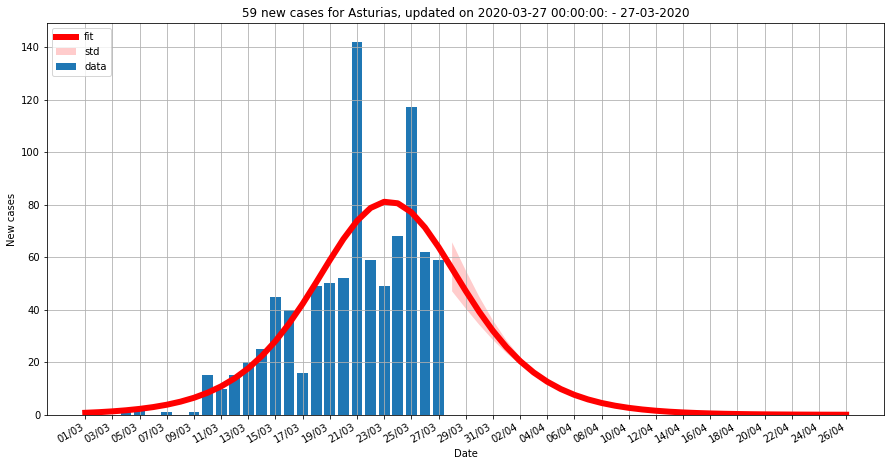

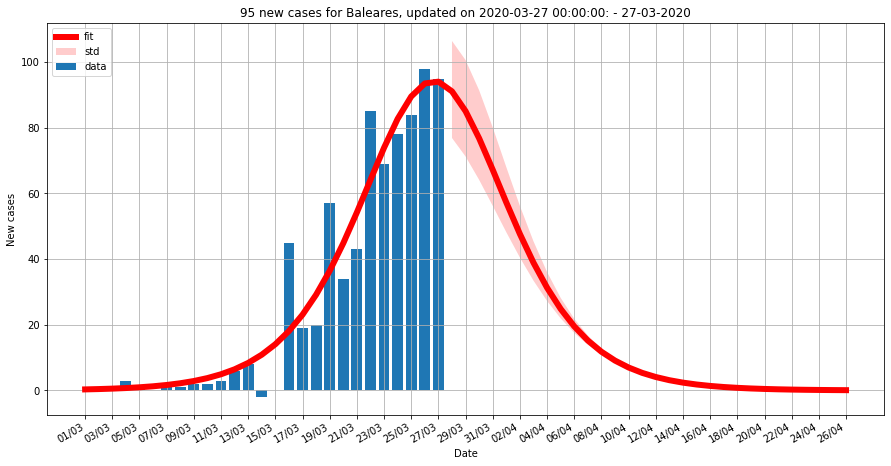

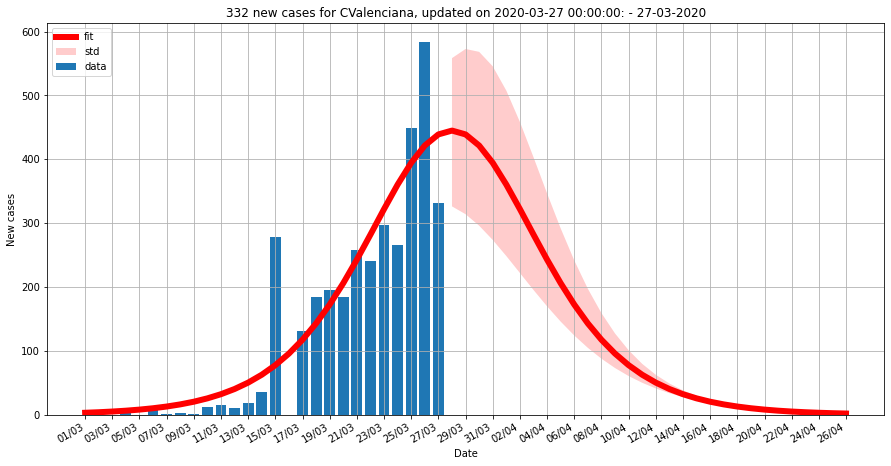

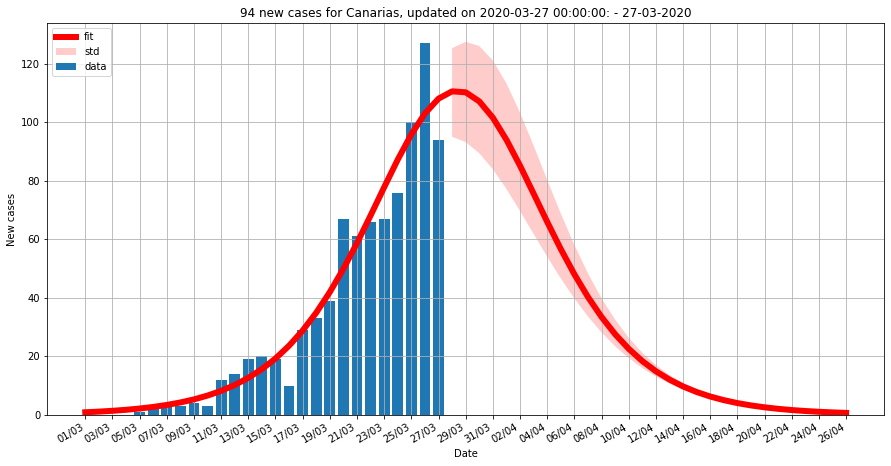

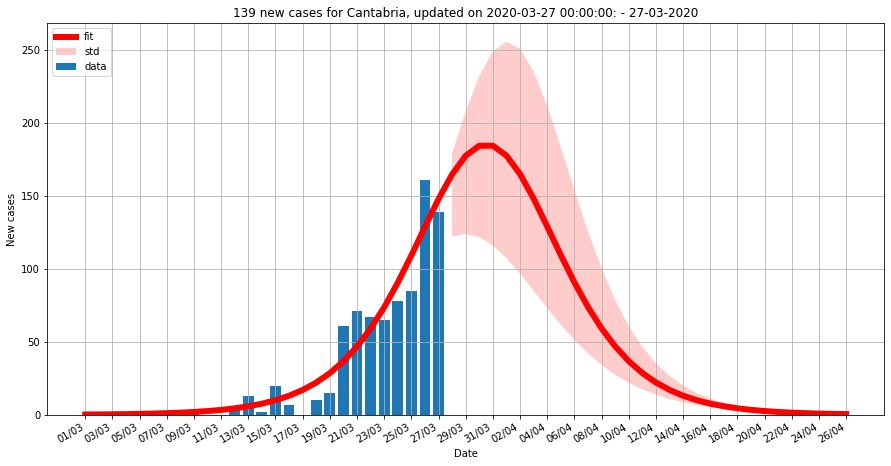

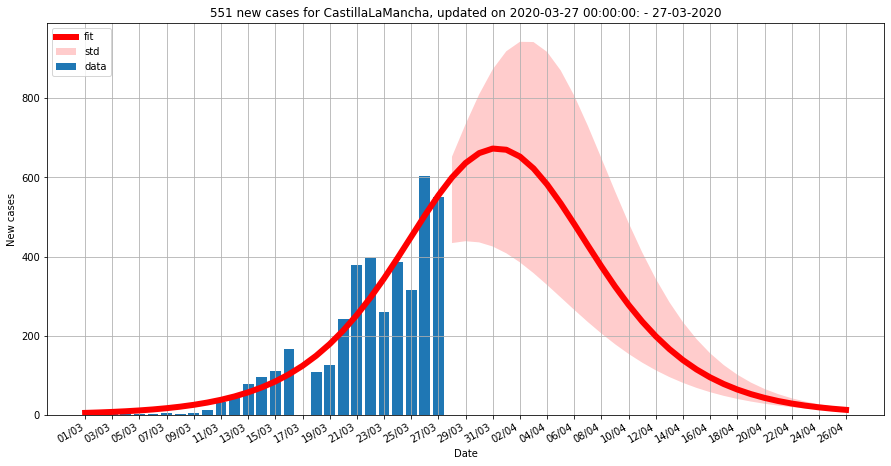

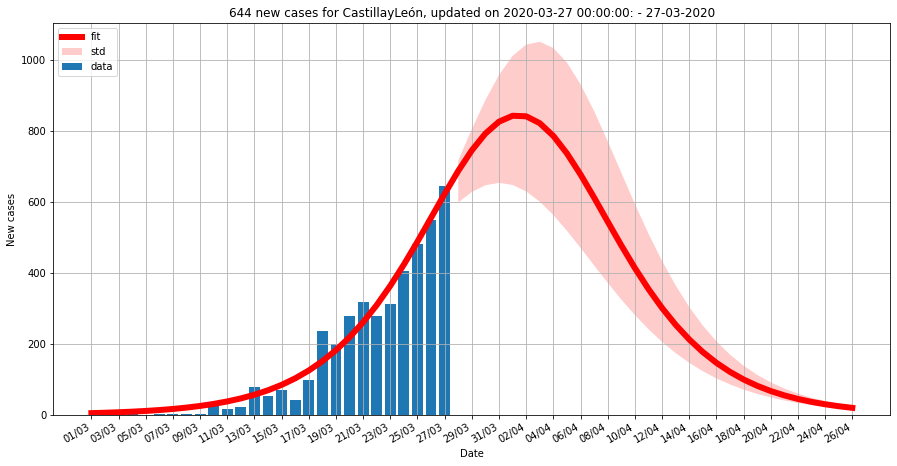

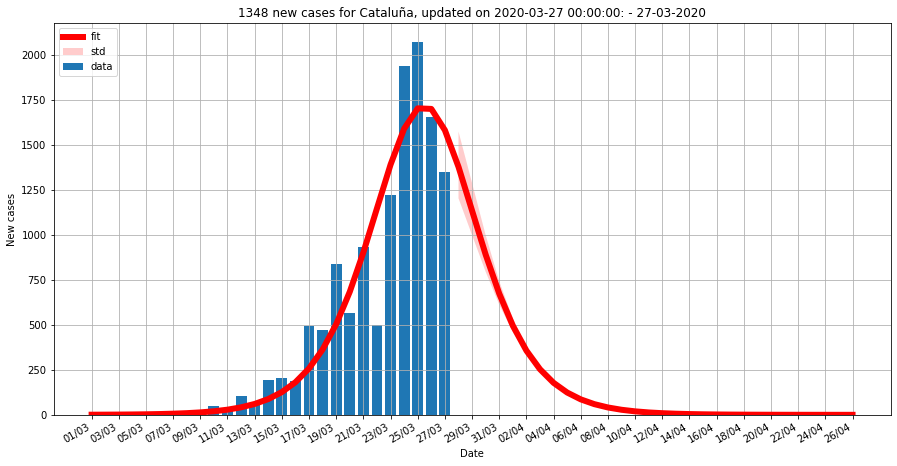

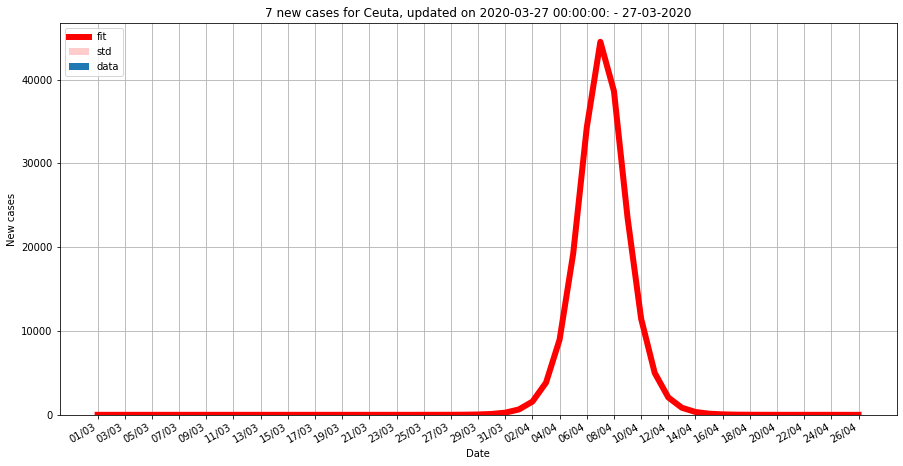

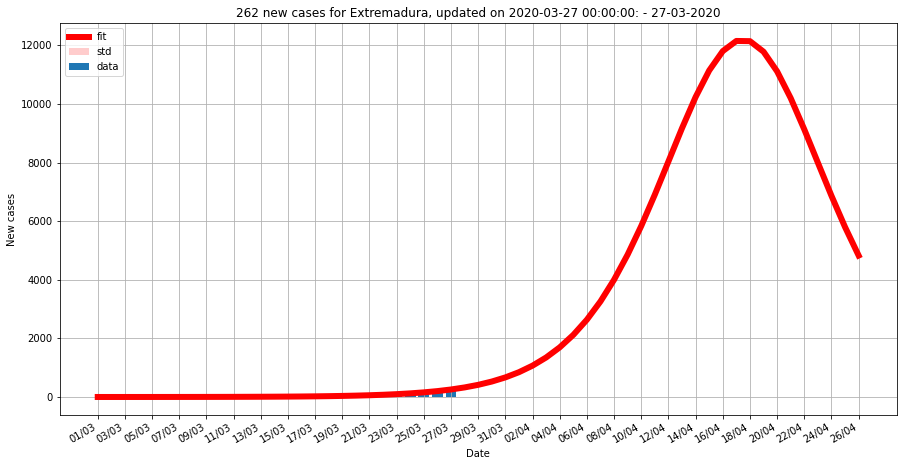

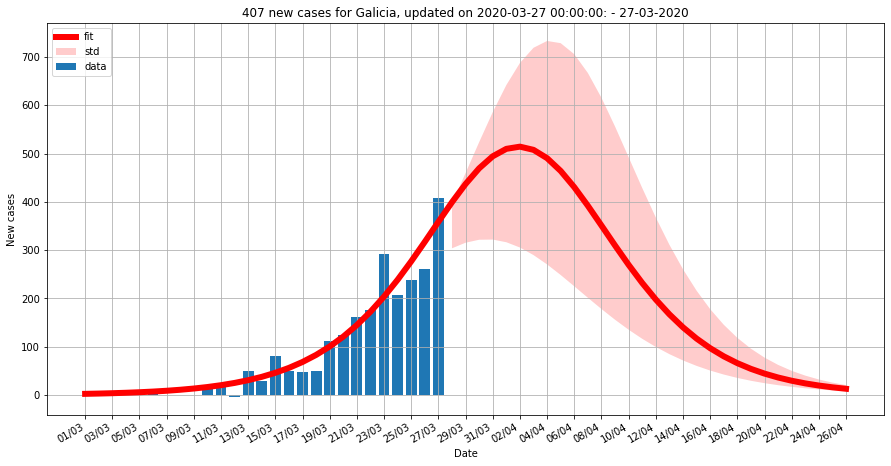

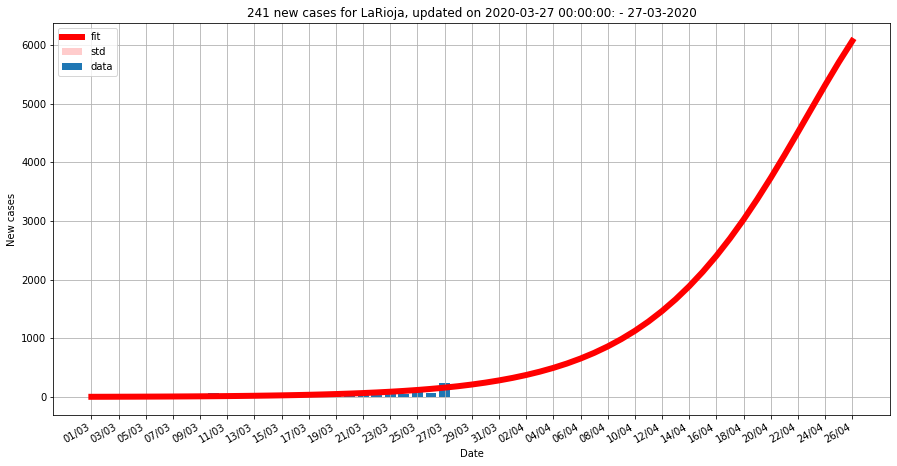

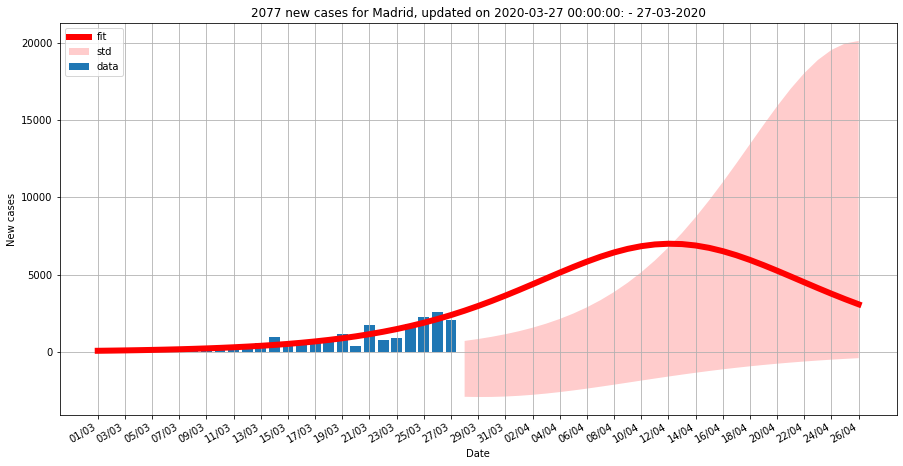

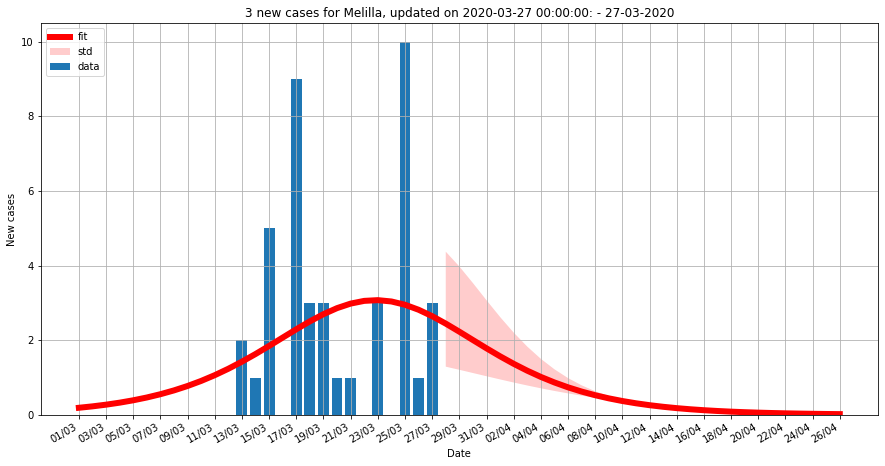

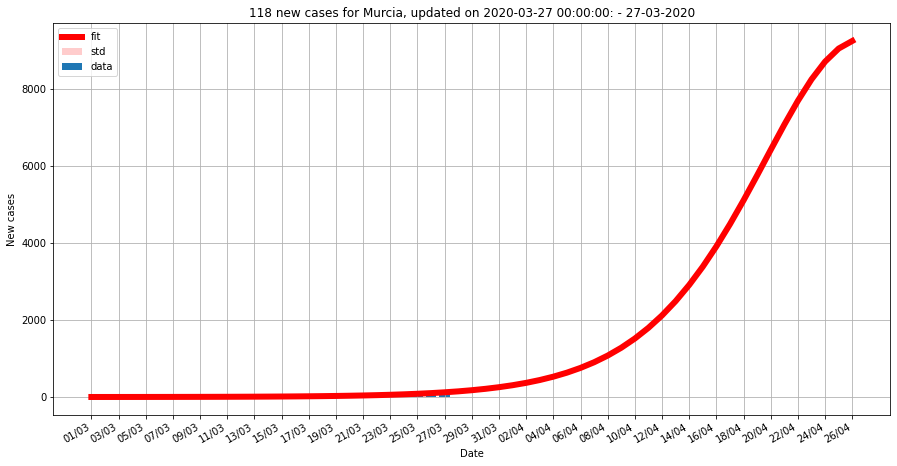

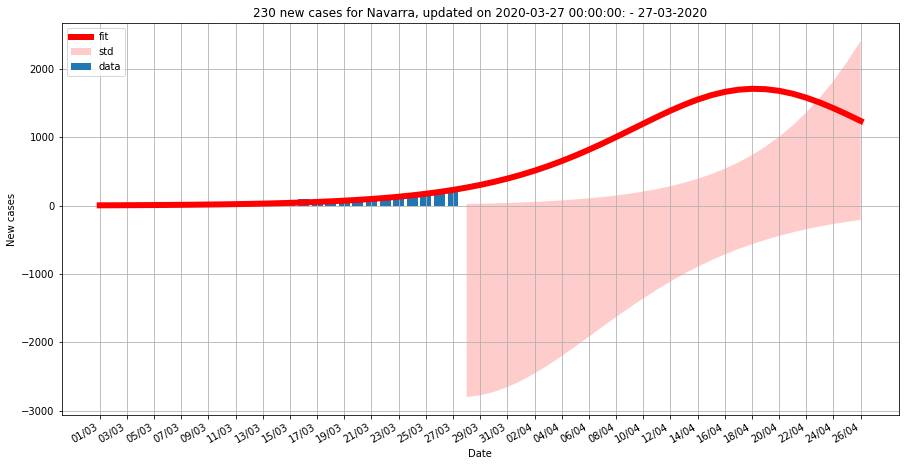

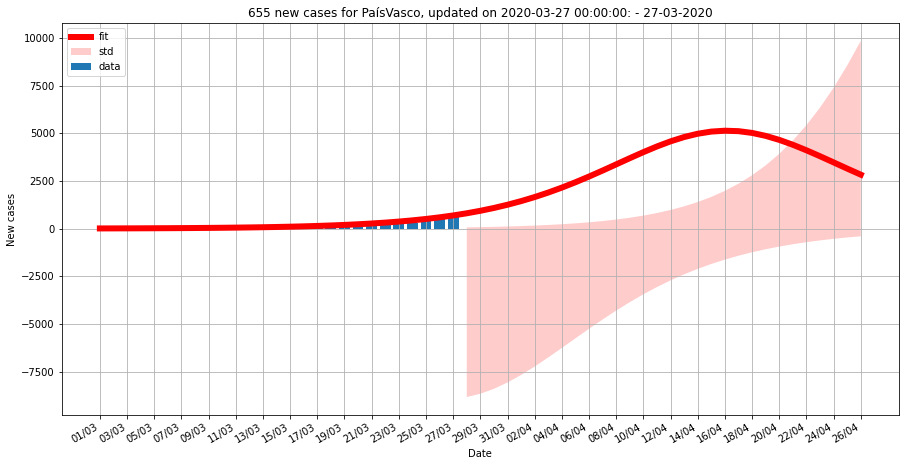

In [28]:
for CCAA in data.CCAA.unique():
    newCasesCCAA = np.diff(data[data.CCAA==CCAA].casos.values)
    Titulo = '{:.0f} new cases for {}, updated on {}:'.format(newCasesCCAA[-1],CCAA,dates[-1])
    fit_curve(logistic_derivative, newCasesCCAA, Titulo, 'New cases', last_date, coeff_std_d);